# AR(p)
# Autoregressive Model


In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html'>ar_model.AR</a></strong><font color=black>(endog[, dates, freq, missing])</font>&nbsp;&nbsp;Autoregressive AR(p) model<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.html'>ar_model.ARResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an AR model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/AR.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive models</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive model</font></div>

## Perform standard imports and load datasets
For this exercise we'll look at monthly U.S. population estimates in thousands from January 2011 to December 2018 (96 records, 8 years of data). Population includes resident population plus armed forces overseas. The monthly estimate is the average of estimates for the first of the month and the first of the following month.
Source: https://fred.stlouisfed.org/series/POPTHM

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

# Load the U.S. Population dataset
df = pd.read_csv('uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


## Plot the source data

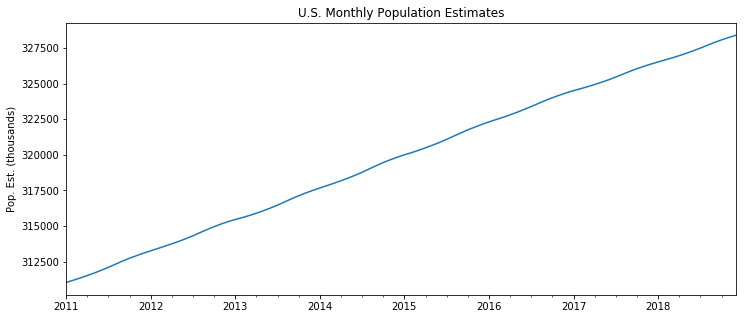

In [4]:
title='U.S. Monthly Population Estimates'
ylabel='Pop. Est. (thousands)'
xlabel='' # we don't really need a label here

ax = df['PopEst'].plot(figsize=(12,5),title=title);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

<div class="alert alert-info"><strong>NOTE: </strong>For many training and testing applications we would use the <tt>train_test_split()</tt> function available from Python's <a href='https://scikit-learn.org/stable/'>scikit-learn</a> library. This won't work here as <tt>train_test_split()</tt> takes <em>random samples</em> of data from the population.</div>

In [5]:
len(df)

96

In [12]:
# Set one year for testing
# train and test is not a random selection
# we actually select the last values
train = df.iloc[:84]
test = df.iloc[84:]

In [36]:
print(len(train))
print(len(test))

84
12


## Fit an AR(1) Model

In [10]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [38]:
model = AR(train['PopEst'])
AR1fit = model.fit(
    # number of points to look backwards
    maxlag=1,
    # mle uses the estimated point
    method='mle')

In [39]:
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const        149.434881
L1.PopEst      0.999530
dtype: float64


In [40]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end).rename('AR(1) Predictions')

In [41]:
predictions1

2018-01-01    326374.147959
2018-02-01    326370.297727
2018-03-01    326366.449303
2018-04-01    326362.602687
2018-05-01    326358.757877
2018-06-01    326354.914873
2018-07-01    326351.073674
2018-08-01    326347.234279
2018-09-01    326343.396687
2018-10-01    326339.560898
2018-11-01    326335.726910
2018-12-01    326331.894723
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [23]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]:<11.10}, expected={test['PopEst'][i]}")

predicted=326374.148 , expected=326527
predicted=326370.2977, expected=326669
predicted=326366.4493, expected=326812
predicted=326362.6027, expected=326968
predicted=326358.7579, expected=327134
predicted=326354.9149, expected=327312
predicted=326351.0737, expected=327502
predicted=326347.2343, expected=327698
predicted=326343.3967, expected=327893
predicted=326339.5609, expected=328077
predicted=326335.7269, expected=328241
predicted=326331.8947, expected=328393


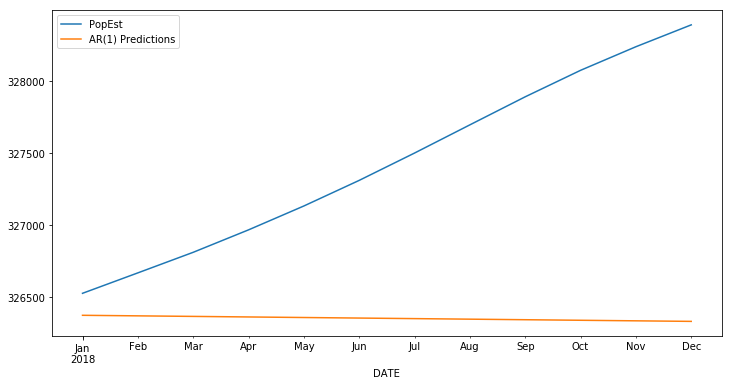

In [24]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

## Fit an AR(2) Model

In [26]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        128.075327
L1.PopEst      1.996565
L2.PopEst     -0.996967
dtype: float64


In [27]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end).rename('AR(2) Predictions')

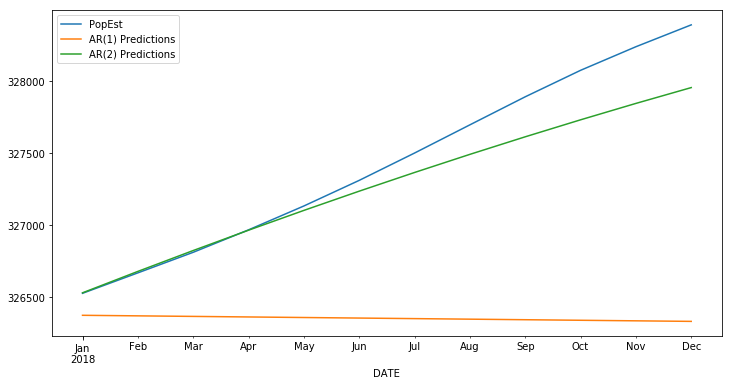

In [28]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## Fit an AR(p) model where statsmodels chooses p
This time we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [35]:
ARfit = model.fit(
    # ponderate the complexity compared to error
    ic='t-stat')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 12
Coefficients:
const         84.885175
L1.PopEst      2.296674
L2.PopEst     -2.109518
L3.PopEst      1.429221
L4.PopEst     -1.259837
L5.PopEst      1.093852
L6.PopEst     -0.985774
L7.PopEst      1.066295
L8.PopEst     -0.858709
L9.PopEst      0.826672
L10.PopEst    -1.074975
L11.PopEst     1.034535
L12.PopEst    -0.458679
dtype: float64


In [30]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(12) Predictions'

predictions11 = ARfit.predict(start=start,end=end).rename(rename)

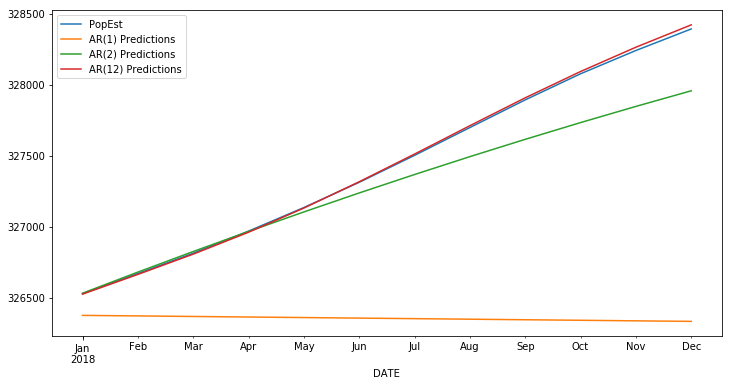

In [31]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [33]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 1553500.453
AR(2) Error: 50682.31966
AR(11) Error: 186.9705375


## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

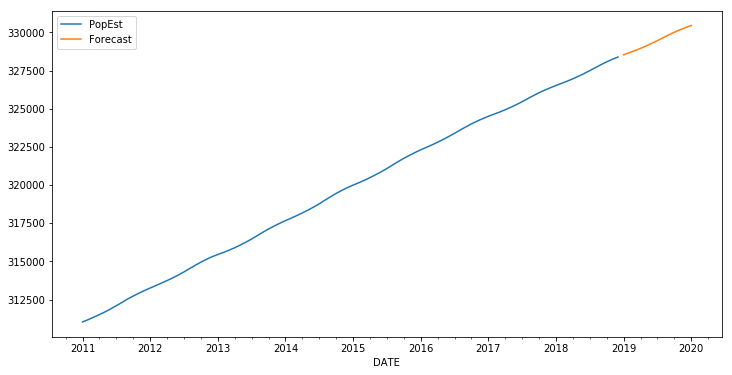

In [34]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit(maxlag=12)

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+12).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));